# Linear Systems 

In this post, we will learn how to solve linear systems such as

$$Ax = b $$

In [138]:
import time
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt 
%config InlineBackend.figure_formats = ['svg']

In [42]:
A = np.array(
    [
        [1, 1, 1, 1],
        [1, 4, 2, 3],
        [4, 7, 8, 9]
    ],
    dtype=np.float64
)

In [9]:
A[1, 0:] -= (A[1, 0]/A[0, 0])*A[0]  # Gaussian elimination
A[2, 0:] -= (A[2, 0]/A[0, 0])*A[0]
A[2, 1:] -= (A[2, 1]/A[1, 1])*A[1, 1:]
A

array([[1., 1., 1., 1.],
       [0., 3., 1., 2.],
       [0., 0., 3., 3.]], dtype=float32)

## Round-off Error

Gaussian elimination is not always numerically stable. In other words, 
it is susceptible to rounding error that may result in an incorrect final matrix. 
Suppose that, due to round-off error, the matrix A has a very small entry 
on the diagonal.

$$A = \begin{bmatrix} 10^{-15} & 1 \\ -1 & 0 \end{bmatrix}$$

Though $10^{-15}$ is essentially zero, instead of swapping the first and 
second rows to put $A$ in REF, a computer might multiply the first row by
$10^{-15}$, then we will have 

$$
A = \begin{bmatrix} 10^{-15} & 1 \\ -1 & 0 \end{bmatrix} \to
\begin{bmatrix} 10^{-15} & 1 \\ 0 & 10^{15}\end{bmatrix}
$$

Round-off error can propagate through many steps in a calculation. 
The NumPy routines that employ row reduction use several tricks to 
minimize the impact of round-off error, but these tricks cannot fix every matrix.

we will perform a series of steps called row operations which preserve the solution of the system while gradually making the solution more accessible. There are three such operations we may perform.

1. Exchange the position of two equations.

2. Multiply an equation by any nonzero number.

3. Replace any equation with the sum of itself and a multiple of another equation.



In [29]:
def row_operation(A:np.ndarray) -> np.ndarray:
    """
    Rwo operation on n matrix A that is invertible and no zeros 
    in the diagonal (this means that A[0, 0] is not 0 for sure, A[1, 1])
    """
    n = A.shape[0]  # A is a square matrix 
    for i in range(n):
        # scale the ith row into the unit one
        A[i, i:] = A[i, i:]/A[i, i]
        # loop over all row elements of column i 
        # start from i+1 to n 
        for j in range(i+1, n):
            # initialize the elementary matrix
            mat = np.eye(n)  
            scalar = -A[j, i]
            mat[j, i] = scalar
            # implement elementary matrix elimination 
            A = mat @ A 
            
    return A

In [48]:
a1 = np.array(
    [
        [1, 1, 1],
        [1, 4, 2],
        [4, 7, 8]
    ],
    dtype=np.float64
)
row_operation(a1)

array([[1.        , 1.        , 1.        ],
       [0.        , 1.        , 0.33333333],
       [0.        , 0.        , 1.        ]])

In [31]:
fooa = np.random.randint(10, size=(4, 4))
row_operation(fooa)

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.5       , 1.25      ],
       [0.        , 0.        , 1.        , 1.21428571],
       [0.        , 0.        , 0.        , 1.        ]])

## The LU Decomposition

The _LU decomposition_ of a square matrix $A$ is a factorization

$$A = LU$$ 

where $U$ is the upper upper triangular REF of  $A$ and $L$ is the lower 
triangular product of the type III elementary matrices whose inverses reduce
$A$ to $U$. 

The $LU$ decomposition of $A$ exists when $A$ can be reduced to REF using only 
type III elementary matrices (without any row swaps).  However, the rows 
of $A$ can always be permuted in a way such that the decomposition exists.

If $P$ is a permutation matrix encoding the appropriate row swaps, 
then the decomposition 

$$PA = LU$$ 

always exists.

Now, suppose the decomposition exists without permutation, then we could have

$$
E_k\cdots E_2E_1 A = U  \ \ \to \ \ A = (E_k\cdots E_2E_1 )^{-1}U = LU 
$$

Pseudo code for a simple  $LU$  factorization for a square matrix $A$ 

1. Initialize a $n \times n$ matrix $L=I$ and $U=A$
2. for $i = 1, \cdots, n$ do step 3
3.  for $j = i+1, \cdots, n$ do step 4-5
4.    set $L[j, i] = U[j, i]/U[i, i]$
5.    set $U[j] = (U[j]-L[j, i]U[i])$


In [55]:
def lu_decompose(A: np.ndarray) -> np.ndarray:
    """
    LU decomposition for a square matrix which is assumed to be decomposed 
    It is similar with row_operation() function but 
    we will do operation on element-wise 
    """
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n)
    
    for i in range(n):
        # get the factor vector 
        factor = U[i+1:, i]/U[i, i]
        L[i+1:, i] = factor 
        U[i+1:] -= factor[:, np.newaxis]*U[i]
            
    return L, U 

In [56]:
al, au = lu_decompose(a1)

In [57]:
al

array([[1., 0., 0.],
       [1., 1., 0.],
       [4., 1., 1.]])

In [58]:
au

array([[1., 1., 1.],
       [0., 3., 1.],
       [0., 0., 3.]])

In [62]:
al @ au == a1

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

## PLU  factorization 

Pseudo code for a simple  $PLU$  factorization for a square matrix $A$ 

1. Initialize a $n \times n$ matrix $L=P=I$ and $U=A$
2. for $i = 1, \cdots, n$ do step 3-4, 8
3.  let $k=i$
4.  while $u_{ii} = 0$, do step 5-7
5.    swap row $U_i$ with row $U_{k+1}$
6.    swap row $P_i$ with row $P_{k+1}$
7.    increase $k$ by 1
8.  for $j = i+1, \cdots, n$ do step 9-10
9.    set $L[j, i] = U[j, i]/U[i, i]$
10.   set $U[j] = (U[j]-L[j, i]U[i])$


In [101]:
def plu(A: np.ndarray) -> np.ndarray:
    """
    LU decomposition with permutation 
    @ John T. Foster, Jr
    """
    n = A.shape[0]
    U = A.copy().astype(np.float64)
    L = np.eye(n, dtype=np.float64)
    P = np.eye(n, dtype=np.float64)
    for i in range(n):
        for k in range(i, n):
            # 1e-10 == 0.0  (false)
            # np.isclose(1e-10, 0.0) (True)
            if ~np.isclose(U[i, i], 0.0):
                # if not close, no need to swap
                break
            U[[k, k+1]] = U[[k+1, k]]  # swap rows with list [k, k+1]
            P[[k, k+1]] = P[[k+1, k]]
            
        # get the factor vector 
        factor = U[i+1:, i]/U[i, i]
        L[i+1:, i] = factor 
        U[i+1:] -= factor[:, np.newaxis]*U[i]
    
    return P, L, U

In [93]:
a2 = np.array([[2, 5, 8, 7], [5, 2, 2, 8], [7, 5, 6, 6], [5, 4, 4, 8]])
a2

array([[2, 5, 8, 7],
       [5, 2, 2, 8],
       [7, 5, 6, 6],
       [5, 4, 4, 8]])

In [94]:
p, l, u = sp.linalg.lu(a2)

In [95]:
p

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [96]:
l

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.28571429,  1.        ,  0.        ,  0.        ],
       [ 0.71428571,  0.12      ,  1.        ,  0.        ],
       [ 0.71428571, -0.44      , -0.46153846,  1.        ]])

In [97]:
u

array([[ 7.        ,  5.        ,  6.        ,  6.        ],
       [ 0.        ,  3.57142857,  6.28571429,  5.28571429],
       [ 0.        ,  0.        , -1.04      ,  3.08      ],
       [ 0.        ,  0.        ,  0.        ,  7.46153846]])

In [102]:
p, l, u = plu(a2)

In [105]:
p @ l @ u  # scipy uses the different algorithms 

array([[2., 5., 8., 7.],
       [5., 2., 2., 8.],
       [7., 5., 6., 6.],
       [5., 4., 4., 8.]])

## Forward and Backward Substitution

If we have $PA = LU$ and $Ax =b$, then 

$$PAx = Pb  \ \ \to LUx = Pb  \ \ \to Ly = Pb \ \ (y = Ux) $$

Since the diagonal entries of $L$ are all 1 , the triangular system 
$L \mathbf{y}=\mathbf{b}$ has the form

$$
\left[\begin{array}{ccccc}
1 & 0 & 0 & \cdots & 0 \\
l_{21} & 1 & 0 & \cdots & 0 \\
l_{31} & l_{32} & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
l_{n 1} & l_{n 2} & l_{n 3} & \cdots & 1
\end{array}\right]\left[\begin{array}{c}
y_1 \\
y_2 \\
y_3 \\
\vdots \\
y_n
\end{array}\right]=\left[\begin{array}{c}
b_1 \\
b_2 \\
b_3 \\
\vdots \\
b_n
\end{array}\right] .
$$


This gives the forward substitution as th matrix multiplication yields the equations
$$
\begin{array}{rlrl}
y_1 & =b_1, & y_1 & =b_1, \\
l_{21} y_1+y_2 & =b_2, & y_2 & =b_2-l_{21} y_1, \\
\vdots & \vdots & \vdots \\
\sum_{j=1}^{k-1} l_{k j} y_j+y_k & =b_k, & y_k & =b_k-\sum_{j=1}^{k-1} l_{k j} y_j
\end{array}
$$

The triangular system $U \mathbf{x}=\mathbf{y}$ yields similar equations, but in reverse order:
$$
\left[\begin{array}{ccccc}
u_{11} & u_{12} & u_{13} & \cdots & u_{1 n} \\
0 & u_{22} & u_{23} & \cdots & u_{2 n} \\
0 & 0 & u_{33} & \cdots & u_{3 n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & u_{n n}
\end{array}\right]\left[\begin{array}{c}
x_1 \\
x_2 \\
x_3 \\
\vdots \\
x_n
\end{array}\right]=\left[\begin{array}{c}
y_1 \\
y_2 \\
y_3 \\
\vdots \\
y_n
\end{array}\right] 
$$ 

$$
\begin{aligned}
u_{n,n}x_n = y_n \quad  & x_n = \frac{1}{u_{n, n}} y_n   \\ 
u_{n-1, n-1} x_{n-1}+u_{n-1, n} x_n=y_{n-1}, \quad & x_{n-1}=\frac{1}{u_{n-1, n-1}}\left(y_{n-1}-u_{n-1, n} x_n\right),  \\
\vdots \quad & \vdots \\
\sum_{j=k}^n u_{k j} x_j=y_k, \quad &  x_k=\frac{1}{u_{k k}}\left(y_k-\sum_{j=k+1}^n u_{k j} x_j\right) 
\end{aligned}
$$

In [113]:
def forward_substitution(L: np.ndarray, b:np.ndarray) -> np.ndarray:
    """
    Doing forward substitution 
    """
    m, n = L.shape
    # initialize y 
    y = np.zeros_like(b)
    
    y[0] = b[0] / L[0, 0]
    
    for i in range(1, m):
        y[i] = (b[i]-np.dot(L[i, :i], y[:i])) / L[i, i]
        
    return y 

In [114]:
def backward_substitution(U, y):
    """
    Doing backward substitution 
    """
    m, n = U.shape
    x = np.zeros_like(y)
    
    x[-1] = y[-1]/U[-1, -1]
    
    for i in range(m-2, -1, -1):
        x[i] = (y[i]-np.dot(U[i, i:], x[i:])) / U[i, i]
        
    return x 

In [111]:
def lu_solve(A, b):
    """
    LU solver: assumes A does not need permutation
    """
    L, U = lu_decompose(A)
    y = forward_substitution(L, b)
    x = backward_substitution(U, y)
    
    return x

In [115]:
A = np.array([[1, 4, 5], [6, 8, 22], [32, 5., 5]])
b = np.array([1, 2, 3.])
lu_solve(A, b)

array([ 0.05614973,  0.25935829, -0.01871658])

In [116]:
np.linalg.solve(A, b)

array([ 0.05614973,  0.25935829, -0.01871658])

In [117]:
def plu_solve(A, b):
    """
    PLU solver
    """
    P, L, U = plu(A)
    y = forward_substitution(L, P@b)
    x = backward_substitution(U, y)
    
    return x

In [118]:
A = np.array([[0, 4, 5], [6, 8, 22], [32, 5., 5]])
b = np.array([1, 2, 3.])

plu_solve(A, b)

array([ 0.05363985,  0.2835249 , -0.02681992])

In [119]:
np.linalg.solve(A, b)

array([ 0.05363985,  0.2835249 , -0.02681992])

In [122]:
def doolittle(A):
    """
    doo little for the square matrix
    """
    n = A.shape[0]
    U = np.zeros((n, n))
    L = np.eye(n)
    
    for i in range(n):
        U[i, i:] = A[i, i:] - L[i, :i] @ U[:i, i:]
        L[(i+1):, i] = (A[(i+1):, i] - L[(i+1):, :] @ U[:, i]) / U[i, i]
        
    return L, U

In [123]:
A = np.array([[1, 4, 5], [6, 8, 22], [32, 5., 5]])
L, U = doolittle(A)
L

array([[ 1.    ,  0.    ,  0.    ],
       [ 6.    ,  1.    ,  0.    ],
       [32.    ,  7.6875,  1.    ]])

In [124]:
U

array([[  1. ,   4. ,   5. ],
       [  0. , -16. ,  -8. ],
       [  0. ,   0. , -93.5]])

In [125]:
L @ U 

array([[ 1.,  4.,  5.],
       [ 6.,  8., 22.],
       [32.,  5.,  5.]])

In [129]:
# create a linear system 
mat_a = np.random.randint(100, size=(97, 97))
mat_x = np.random.rand(97,1)
b = mat_a @ mat_x

In [160]:
mat_size = 2**np.arange(12)

inv_times = []
solve_times = []
lu_times = []
lu_solve_times = []

for n in mat_size:
    # create a linear system
    temp_a = np.random.randint(100, size=(n, n))
    temp_x = np.random.rand(n, 1)
    b = temp_a @ temp_x
    # solve it with different methods
    
    start = time.time()
    sp.linalg.inv(temp_a) @ b
    inv_times.append(time.time()-start)
    
    start = time.time()
    sp.linalg.solve(temp_a, b)
    solve_times.append(time.time()-start)
    
    start = time.time()
    lu, p = sp.linalg.lu_factor(temp_a)
    sp.linalg.lu_solve((lu, p), b)
    lu_times.append(time.time()-start)
    
    lu, p = sp.linalg.lu_factor(temp_a)
    start = time.time()
    sp.linalg.lu_solve((lu, p), b)
    lu_solve_times.append(time.time()-start)

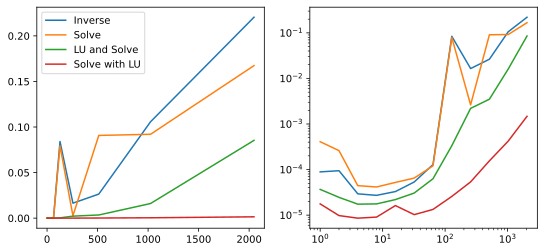

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
vis_data = {
    "Inverse": inv_times,
    "Solve": solve_times,
    "LU and Solve": lu_times,
    "Solve with LU": lu_solve_times
}
axes = axes.flatten()

for item in vis_data.items():
    axes[0].plot(mat_size, item[1], label=item[0])
    axes[1].loglog(mat_size, item[1])

axes[0].legend(loc='upper left');

The above figure demonstrates that computing a matrix inverse is computationally expensive. In fact, numerically inverting matrices is so costly that there is hardly ever a good reason to do it. Use a specific solver like la.lu_solve() whenever possible instead of using la.inv().